In [22]:
# import relevant modules 

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from os.path import join as osjoin
from time import time
t_start = time()

# Data from https://www.kaggle.com/datasets/pavankrishnanarne/global-stock-market-2008-present

In [23]:
# load data file
year = 2010
data = pd.read_csv(osjoin("Global_Market_Data", str(year) + "_Global_Markets_Data.csv"))

In [24]:
# load data file and join years together
years_included = [str(2008+i) for i in range(12)]
data = pd.read_csv(osjoin("Global_Market_Data", years_included[0] + "_Global_Markets_Data.csv"))
for year in years_included[1:]:
    data = pd.concat([data, pd.read_csv(osjoin("Global_Market_Data", year + "_Global_Markets_Data.csv"))], ignore_index=True) 

In [25]:
data.Ticker.unique()

array(['^NYA', '^IXIC', '^FTSE', '^NSEI', '^BSESN', '^N225', '000001.SS',
       '^N100', '^DJI', '^GSPC', 'GC=F', 'CL=F'], dtype=object)

In [26]:
# Show some info on the data
print(data.head())
print(data.describe())

   Ticker        Date          Open          High           Low         Close  \
0    ^NYA  2008-08-01   8438.709961   8452.009766   8356.429688   8379.150391   
1   ^IXIC  2008-08-01   2326.830078   2328.949951   2286.409912   2310.959961   
2   ^FTSE  2008-08-01   5411.899902   5411.899902   5321.299805   5354.700195   
3   ^NSEI  2008-08-01   4331.600098   4422.950195   4235.700195   4413.549805   
4  ^BSESN  2008-08-01  14064.259766  14682.330078  14032.870117  14656.690430   

      Adj Close        Volume  
0   8379.150391  4.684870e+09  
1   2310.959961  2.312140e+09  
2   5354.700195  1.341947e+09  
3   4413.549805  0.000000e+00  
4  14656.690430  4.020000e+04  
               Open          High           Low         Close     Adj Close  \
count  34179.000000  34179.000000  34179.000000  34179.000000  34179.000000   
mean    7457.879822   7499.287432   7410.326992   7455.974776   7455.974776   
std     7935.382909   7970.539899   7889.797629   7929.661813   7929.661813   
min  

# Creating FTSE-only data set

In [27]:
FTSE = data[data["Ticker"] == "^FTSE"]

In [28]:
FTSE.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
2,^FTSE,2008-08-01,5411.899902,5411.899902,5321.299805,5354.700195,5354.700195,1.341947e+09
14,^FTSE,2008-08-04,5354.700195,5414.700195,5310.299805,5320.200195,5320.200195,9.720983e+08
26,^FTSE,2008-08-05,5320.200195,5454.500000,5299.700195,5454.500000,5454.500000,1.655153e+09
38,^FTSE,2008-08-06,5454.500000,5498.600098,5440.100098,5486.100098,5486.100098,1.634412e+09
50,^FTSE,2008-08-07,5486.100098,5539.299805,5450.899902,5477.500000,5477.500000,1.552156e+09


In [29]:
# drop irrelevant columns
FTSE.drop(columns=["Adj Close"], inplace=True)

C:\Users\Bradley\AppData\Local\Temp\ipykernel_16144\1296024085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FTSE.drop(columns=["Adj Close"], inplace=True)


In [30]:
# convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])
# sort by date
data = data.sort_values('Date').reset_index(drop=True)

In [31]:
#fig, (ax1, ax2) = plt.subplots(2, sharex=True)
#ax1.plot(FTSE.Date, FTSE.Close, 'k-')
#ax1.plot(FTSE.Date, FTSE.Open, 'b-')
#ax2.plot(FTSE.Date, FTSE.Close - FTSE.Open, '.k')

### Create columns with lag features

In [32]:
max_days_lag = 25
features = []

for col in ['Close', 'Low', 'High', 'Volume']:
    for i in range(1, max_days_lag+1):  
        FTSE[f'{col}_lag_{i}'] = FTSE[col].shift(i)
        features += [f'{col}_lag_{i}'] 


# Drop rows with NaN values (due to creating lag features)
FTSE.dropna(inplace=True)

C:\Users\Bradley\AppData\Local\Temp\ipykernel_16144\2476726736.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FTSE[f'{col}_lag_{i}'] = FTSE[col].shift(i)
C:\Users\Bradley\AppData\Local\Temp\ipykernel_16144\2476726736.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  FTSE[f'{col}_lag_{i}'] = FTSE[col].shift(i)


### Split data in training/validation sets

In [33]:
target = 'Close'

X = FTSE[features]
y = FTSE[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Training the model

In [34]:
# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [35]:
y_actual = np.array(y)[-y_pred.size:]

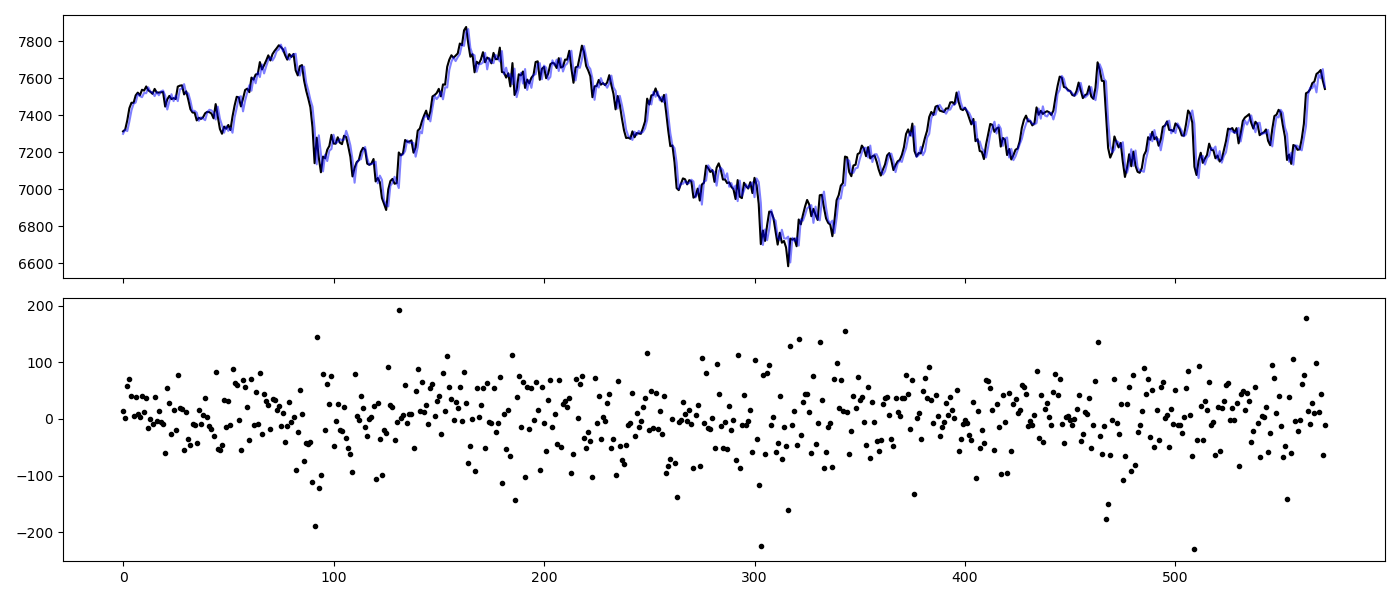

In [36]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
ax1.plot(y_actual, 'k-')
ax1.plot(y_pred, 'b-', alpha=0.5)
ax2.plot(y_actual- y_pred, 'k.')
fig.tight_layout()

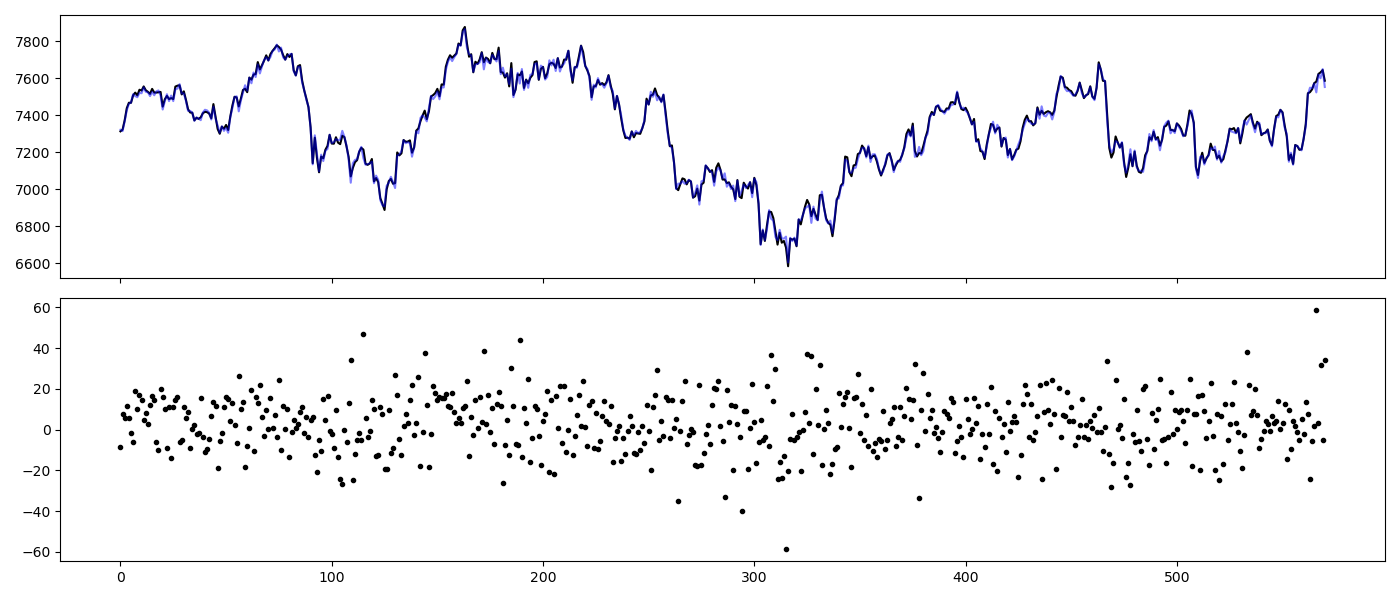

In [37]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
ax1.plot(y_actual[:-1], 'k-')
ax1.plot(y_pred[1:], 'b-', alpha=0.5)
ax2.plot(y_actual[:-1]- y_pred[1:], 'k.')
fig.tight_layout()

In [38]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {mse**0.5}')

Root Mean Squared Error: 55.26552406520918


# Profit/loss calculation

In [39]:
y_open = np.array(FTSE.Open)[-y_pred.size:]

profit = np.sum((y_actual - y_open)[y_pred > y_open])

print("Model profit: £{:.2f}".format(profit))
print("Holding profit: £{:.2f}".format(y_actual[-1] - y_open[0]))

Model profit: £1203.50
Holding profit: £256.70


In [40]:
# calculate days with predicted loss
print(np.sum(y_pred < y_open))
print(np.sum(y_actual < y_open))
print(np.sum((y_pred < y_open) & (y_actual < y_open)))
print(np.sum((y_pred > y_open) & (y_actual > y_open)))

333
272
165
132


In [41]:
# timings 
t_finish = time()
print("Took {:.2f}s".format(t_finish - t_start))

Took 2.17s
